# Multiple seasonalities

> In this example we will show how to forecast data with multiple seasonalities using an MSTL. 

:::{.callout-tip}
For this task, StatsForecast's MSTL is 68% more accurate and 600% faster than [Prophet](https://facebook.github.io/prophet/) and [NeuralProphet](https://neuralprophet.com/). (Reproduce experiments [here](../experiments/mstl))
:::


Multiple seasonal data refers to time series that have more than one clear seasonality. Multiple seasonality is traditionally present in data that is sampled at a low frequency. For example, hourly electricity data exhibits daily and weekly seasonality. That means that there are clear patterns of electricity consumption for specific hours of the day like 6:00pm vs 3:00am or for specific days like Sunday vs Friday. 

Traditional statistical models are not able to model more than one seasonal length. In this example, we will show how to model the two seasonalities efficiently using Multiple Seasonal-Trend decompositions with LOESS (`MSTL`). 

For this example, we will use hourly electricity load data from Pennsylvania, New Jersey, and Maryland (PJM). The original data can be found [here](https://github.com/jnagura/Energy-consumption-prediction-analysis). (Click here for info on [PJM](https://www.pjm.com/about-pjm))

First, we will load the data, then we will use the `StatsForecast.fit` and `StatsForecast.predict` methods to predict the next 24 hours. We will then decompose the different elements of the time series into trends and its multiple seasonalities. At the end, you will use the `StatsForecast.forecast` for production-ready forecasting. 

**Outline**

1. Install libraries
1. Load and explore the data
1. Fit a multiple-seasonality model
1. Decompose the series in trend and seasonality 
1. Predict the next 24 hours
1. Optional: Forecast in production

:::{.callout-tip}
You can use Colab to run this Notebook interactively <a href="https://colab.research.google.com/github/Nixtla/statsforecast/blob/main/nbs/docs/tutorials/MultipleSeasonalities.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
:::


## Install libraries

We assume you have StatsForecast already installed. Check this guide for instructions on [how to install StatsForecast](../getting-started/0_Installation).

Install the necessary packages using `pip install statsforecast`

In [ ]:
#|hide
!pip install statsforecast

## Load Data

The input to StatsForecast is always a data frame in [long format](https://www.theanalysisfactor.com/wide-and-long-data/) with three columns: `unique_id`, `ds` and `y`:

* The `unique_id` (string, int or category) represents an identifier for the series. 

* The `ds` (datestamp or int) column should be either an integer indexing time or a datestamp ideally like YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp.

* The `y` (numeric) represents the measurement we wish to forecast. 
We will rename the 

You will read the data with pandas and change the necessary names.  This step should take around 2s. 

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/panambY/Hourly_Energy_Consumption/master/data/PJM_Load_hourly.csv')
df.columns = ['ds', 'y']
df.insert(0, 'unique_id', 'PJM_Load_hourly')
df = df.sort_values(['unique_id', 'ds']).reset_index(drop=True)
df.tail()

,unique_id,ds,y
32891,PJM_Load_hourly,2001-12-31 20:00:00,36392.0
32892,PJM_Load_hourly,2001-12-31 21:00:00,35082.0
32893,PJM_Load_hourly,2001-12-31 22:00:00,33890.0
32894,PJM_Load_hourly,2001-12-31 23:00:00,32590.0
32895,PJM_Load_hourly,2002-01-01 00:00:00,31569.0


StatsForecast can handle unsorted data, however, for plotting purposes, it is convenient to sort the data frame.

Plot the series using the `plot` method from the `StatsForecast` class. This method prints up to 8 random series from the dataset and is useful for basic EDA. In this case, it will print just one series given that we have just one unique_id. 

:::{.callout-note}
The `StatsForecast.plot` method uses matplotlib as a default engine. You can change to plotly by setting `engine="plotly"`.

:::

In [ ]:
from statsforecast import StatsForecast

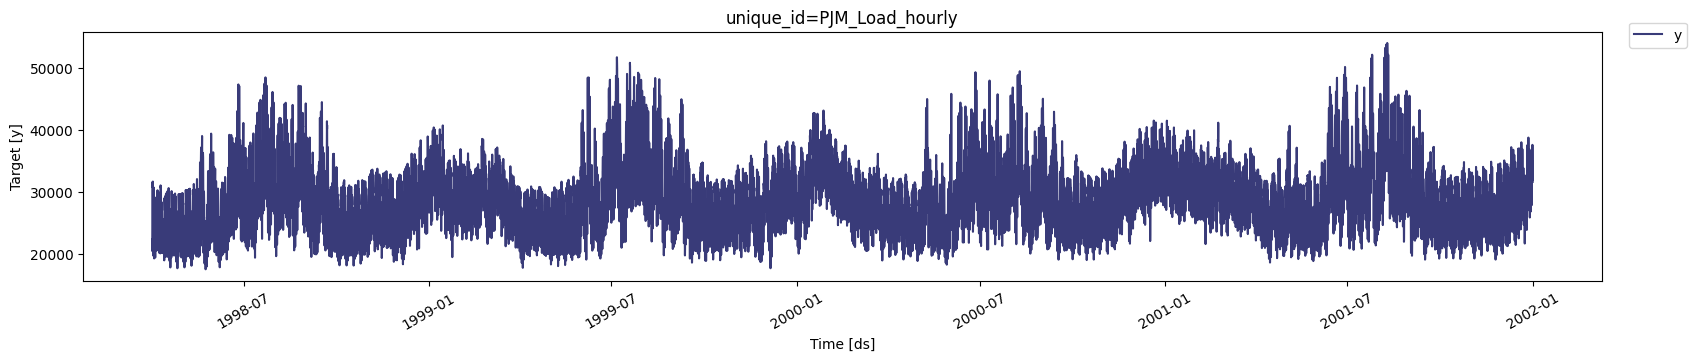

In [ ]:
StatsForecast.plot(df)

The time series exhibits seasonal patterns. Moreover, the time series contains `32,896` observations, so it is necessary to use very computationally efficient methods. 

## Fit an MSTL model

The [MSTL](../models/MultipleSeasonalTrend) (Multiple Seasonal-Trend decompositions using LOESS) model, originally developed by [Kasun Bandara, Rob J Hyndman and Christoph Bergmeir](https://arxiv.org/abs/2107.13462), decomposes the time series in multiple seasonalities using a Local Polynomial Regression (LOESS). Then it forecasts the trend using a non-seasonal model and each seasonality using a [SeasonalNaive](../../models#class-seasonalnaive) model. You can choose the non-seasonal model you want to use to forecast the trend component of the MSTL model. In this example, we will use an [AutoARIMA](../models/AutoARIMA).


Import the models you need. 

In [ ]:
from statsforecast.models import MSTL, AutoARIMA

First, we must define the model parameters. As mentioned before, the electricity load presents seasonalities every 24 hours (Hourly) and every 24 * 7 (Daily) hours. Therefore, we will use `[24, 24 * 7]` for season length. The trend component will be forecasted with an `AutoARIMA` model. (You can also try with: `AutoTheta`, `AutoCES`, and `AutoETS`)

In [ ]:
# Create a list of models and instantiation parameters

models = [MSTL(
    season_length=[24, 24 * 7], # seasonalities of the time series
    trend_forecaster=AutoARIMA() # model used to forecast trend
)]

We fit the models by instantiating a new `StatsForecast` object with the following required parameters:

* `models`: a list of models. Select the models you want from [models](../../models) and import them.

* `freq`: a string indicating the frequency of the data. (See [panda's available frequencies](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases).)

Any settings are passed into the constructor. Then you call its fit method and pass in the historical data frame.

In [ ]:
sf = StatsForecast(
    models=models, # model used to fit each time series
    freq='h', # frequency of the data
)

:::{.callout-tip}
StatsForecast also supports this optional parameter.

* `n_jobs`: n_jobs: int, number of jobs used in the parallel processing, use -1 for all cores. (Default: 1)

* `fallback_model`: a model to be used if a model fails. (Default: none)

:::

Use the `fit` method to fit each model to each time series. In this case, we are just fitting one model to one series. Check this guide to learn how to [fit many models to many series](../getting-started/2_Getting_Started_complete).

:::{.callout-note}
StatsForecast achieves its blazing speed using JIT compiling through Numba. The first time you call the statsforecast class, the fit method should take around 10 seconds. The second time -once Numba compiled your settings- it should take less than 5s.
:::

In [ ]:
sf = sf.fit(df=df)

## Decompose the series

Once the model is fitted, access the decomposition using the `fitted_` attribute of `StatsForecast`. This attribute stores all relevant information of the fitted models for each of the time series.

In this case, we are fitting a single model for a single time series, so by accessing the fitted_ location [0, 0] we will find the relevant information of our model. The `MSTL` class generates a `model_` attribute that contains the way the series was decomposed.

In [ ]:
sf.fitted_[0, 0].model_

,data,trend,seasonal24,seasonal168,remainder
0,22259.0,25899.808157,-4720.213546,581.308595,498.096794
1,21244.0,25900.349395,-5433.168901,571.780657,205.038849
2,20651.0,25900.875973,-5829.135728,557.142643,22.117112
3,20421.0,25901.387631,-5704.092794,597.696957,-373.991794
4,20713.0,25901.884103,-5023.324375,922.564854,-1088.124582
...,...,...,...,...,...
32891,36392.0,33329.031577,4254.112720,917.258336,-2108.402633
32892,35082.0,33355.083576,3625.077164,721.689136,-2619.849876
32893,33890.0,33381.108409,2571.794472,549.661529,-2612.564409
32894,32590.0,33407.105839,796.356548,361.956280,-1975.418667


We will use matplotlib, to visualize the different components of the series.


In [ ]:
import matplotlib.pyplot as plt

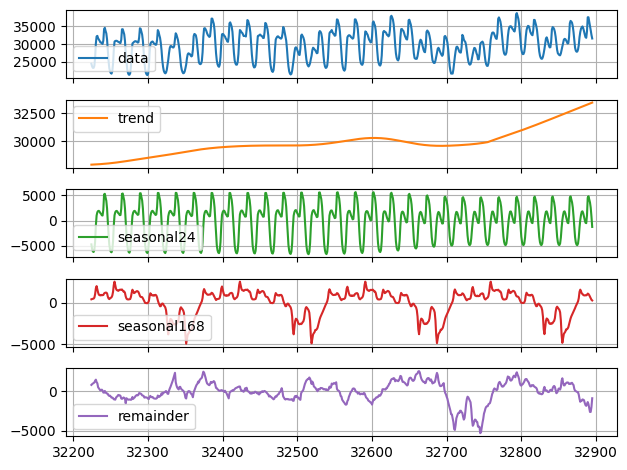

In [ ]:
sf.fitted_[0, 0].model_.tail(24 * 28).plot(subplots=True, grid=True)
plt.tight_layout()
plt.show()

We observe a clear upward trend (orange line) and seasonality repeating every day (24H) and every week (168H).

## Predict the next 24 hours
> Probabilistic forecasting with levels

To generate forecasts use the `predict` method. 

The `predict` method takes two arguments: forecasts the next `h` (for horizon) and `level`.

* `h` (int): represents the forecast h steps into the future. In this case, 12 months ahead. 

* `level` (list of floats): this optional parameter is used for probabilistic forecasting. Set the `level` (or confidence percentile) of your prediction interval. For example, `level=[90]` means that the model expects the real value to be inside that interval 90% of the times. 

The forecast object here is a new data frame that includes a column with the name of the model and the y hat values, as well as columns for the uncertainty intervals. 

This step should take less than 1 second.

In [ ]:
forecasts = sf.predict(h=24, level=[90])
forecasts.head()

,unique_id,ds,MSTL,MSTL-lo-90,MSTL-hi-90
0,PJM_Load_hourly,2002-01-01 01:00:00,30215.608123,29842.185581,30589.030664
1,PJM_Load_hourly,2002-01-01 02:00:00,29447.208519,28787.122830,30107.294207
2,PJM_Load_hourly,2002-01-01 03:00:00,29132.786369,28221.353220,30044.219518
3,PJM_Load_hourly,2002-01-01 04:00:00,29126.252713,27992.819671,30259.685756
4,PJM_Load_hourly,2002-01-01 05:00:00,29604.606314,28273.426621,30935.786006


You can plot the forecast by calling the `StatsForecast.plot` method and passing in your forecast dataframe.

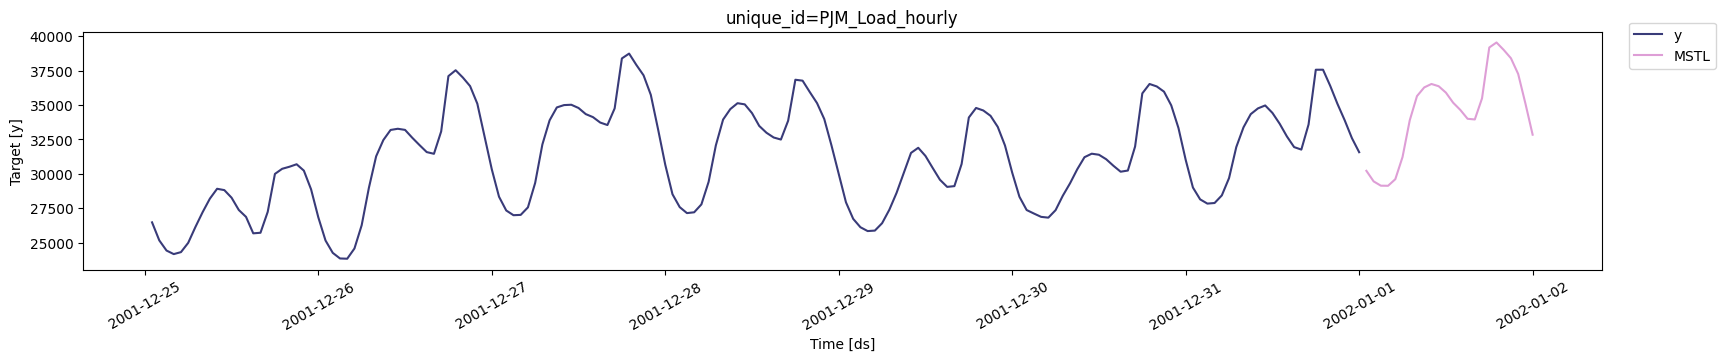

In [ ]:
sf.plot(df, forecasts, max_insample_length=24 * 7)

## Forecast in production

If you want to gain speed in productive settings where you have multiple series or models we recommend using the `StatsForecast.forecast` method instead of `.fit` and `.predict`.

The main difference is that the `.forecast` doest not store the fitted values and is highly scalable in distributed environments. 



The `forecast` method takes two arguments: forecasts next `h` (horizon) and `level`.

* `h` (int): represents the forecast h steps into the future. In this case, 12 months ahead. 

* `level` (list of floats): this optional parameter is used for probabilistic forecasting. Set the `level` (or confidence percentile) of your prediction interval. For example, `level=[90]` means that the model expects the real value to be inside that interval 90% of the times. 

The forecast object here is a new data frame that includes a column with the name of the model and the y hat values, as well as columns for the uncertainty intervals. Depending on your computer, this step should take around 1min. (If you want to speed things up to a couple of seconds, remove the AutoModels like ARIMA and Theta)

:::{.callout-note}
StatsForecast achieves its blazing speed using JIT compiling through Numba. The first time you call the statsforecast class, the fit method should take around 10 seconds. The second time -once Numba compiled your settings- it should take less than 5s.
:::

In [ ]:
forecasts_df = sf.forecast(df=df, h=24, level=[90])
forecasts_df.head()

,unique_id,ds,MSTL,MSTL-lo-90,MSTL-hi-90
0,PJM_Load_hourly,2002-01-01 01:00:00,30215.608123,29842.185581,30589.030664
1,PJM_Load_hourly,2002-01-01 02:00:00,29447.208519,28787.122830,30107.294207
2,PJM_Load_hourly,2002-01-01 03:00:00,29132.786369,28221.353220,30044.219518
3,PJM_Load_hourly,2002-01-01 04:00:00,29126.252713,27992.819671,30259.685756
4,PJM_Load_hourly,2002-01-01 05:00:00,29604.606314,28273.426621,30935.786006


## References

- [Bandara, Kasun & Hyndman, Rob & Bergmeir, Christoph. (2021). “MSTL: A Seasonal-Trend Decomposition Algorithm for Time Series with Multiple Seasonal Patterns”](https://arxiv.org/abs/2107.13462).



## Next Steps
* Learn how to [use cross-validation to assess the robustness of your model](../getting-started/2_Getting_Started_complete#evaluate-the-model%E2%80%99s-performance)